In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("./Data/Liquor_Licenses.csv")

In [6]:
recode = ['BREW_PUB', 'ENTERTAINMENT',
       'SALES_CONSUMPTION', 'SIDEWALK_CAFE', 'SUMMER_GARDEN', 'TASTING',
       'WINE_PUB', 'COVERCHARGE', 'DANCING',
       'OFFPREMISESTORAGE', 'STORAGEFACILITY', 'DISTILLERY_PUB','GAMES_OF_SKILL',
          'SPORTS_WAGGERING']
df[recode] = df[recode].replace({np.nan:0,'CHECKED':1 })


In [7]:
#Replace TYPE
df.TYPE = df.TYPE.replace({'Retail-Class B': 'Retail - Class B',
                'Retail-Liquor Store':'Retail - Liquor Store',
                 'Retail-Full Service Grocery':'Retail - Full Service Grocery'})

In [8]:
# Replace WARD

df.WARD = df.WARD.replace({'Ward 1':1, 'Ward 2':2, 'Ward 3':3,'Ward 4':4,
                          'Ward 5':5, 'Ward 6':6, 'Ward 7':7,'Ward 8':8})

In [9]:
dup_list = df[df.duplicated(subset='LICENSE')].LICENSE.to_list()
dup = df[df.LICENSE.isin(dup_list)]
# Drop duplicates for License and address
df = df.drop_duplicates(subset = ['LICENSE','ADDRESS'], keep = 'last')
# Drop once again to get rid of the row with wrong address for Gallaudet
df = df.drop_duplicates(subset = ['LICENSE'], keep = 'first')

In [11]:
df.shape

(2123, 32)

In [16]:
dc_map = gpd.read_file('./Shapefiles/Washington_DC_Boundary.shp')

<AxesSubplot:>

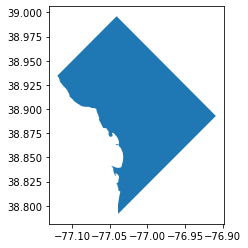

In [17]:
dc_map.plot()

<AxesSubplot:>

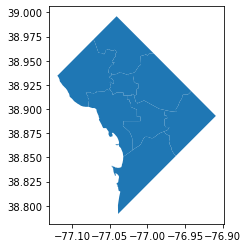

In [18]:
ward = gpd.read_file('./Shapefiles/Ward_from_2012.shp')
ward.plot()

<AxesSubplot:>

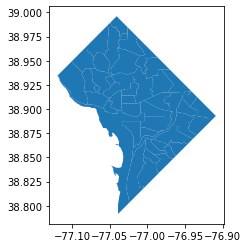

In [19]:
nbh = gpd.read_file('./Shapefiles/Neighborhood_Clusters.shp')
nbh.plot()

In [23]:
geo = [Point(xy) for xy in zip(df['LONGITUDE'], df['LATITUDE'])]

In [24]:
geo_df = gpd.GeoDataFrame(df, geometry = geo)

In [25]:
geo_df.head()

,OBJECTID,LICENSE,TRADE_NAME,APPLICANT,CLASS,ADDRESS,ADDRID,X,Y,STATUS,...,DANCING,OFFPREMISESTORAGE,STORAGEFACILITY,DISTILLERY_PUB,LONGITUDE,LATITUDE,TOTAL_CAPACITY,GAMES_OF_SKILL,SPORTS_WAGGERING,geometry
0,65,ABRA-001750,Decarlos Restaurant,"Spring Valley Enterprises, Inc.",C,4822 YUMA ST NW,302418.0,391727.30,142028.47,Active,...,0,0,0.0,0,-77.095431,38.946113,199.0,0,0,POINT (-77.09543 38.94611)
1,66,ABRA-001792,Folger Shakespeare Library,Trustees of Amherst College,C,201 EAST CAPITOL ST SE,278034.0,399759.90,135732.29,Active,...,0,0,0.0,0,-77.002768,38.889433,NaN,0,0,POINT (-77.00277 38.88943)
2,67,ABRA-001845,Chalin's Restaurant,"C T Chiang of Washington, Inc.",C,1912 I ST NW,300940.0,396178.56,137037.03,Active,...,0,0,0.0,0,-77.044055,38.901179,96.0,0,0,POINT (-77.04406 38.90118)
3,68,ABRA-001926,Potomac Wines And Spirits,"Gabriel, Inc.",A,3100 M ST NW,273837.0,394681.77,137461.07,Active,...,0,1,0.0,0,-77.061314,38.904991,NaN,0,0,POINT (-77.06131 38.90499)
4,69,ABRA-002109,Kusa Market,Sook C. Kim,B,3108 GEORGIA AVE NW,232889.0,397953.74,140168.94,Active,...,0,0,0.0,0,-77.023599,38.929398,NaN,0,0,POINT (-77.02360 38.92940)


<AxesSubplot:>

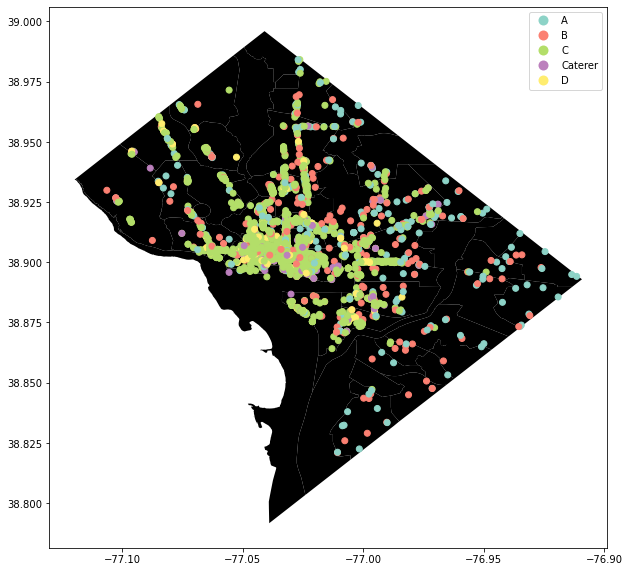

In [48]:
fig, ax= plt.subplots(figsize = (10,10))
nbh.plot(ax = ax, color = 'black')
geo_df.plot(column = 'CLASS', ax= ax, legend = True, cmap = 'Set3' )


In [34]:
df.head()

,OBJECTID,LICENSE,TRADE_NAME,APPLICANT,CLASS,ADDRESS,ADDRID,X,Y,STATUS,...,DANCING,OFFPREMISESTORAGE,STORAGEFACILITY,DISTILLERY_PUB,LONGITUDE,LATITUDE,TOTAL_CAPACITY,GAMES_OF_SKILL,SPORTS_WAGGERING,geometry
0,65,ABRA-001750,Decarlos Restaurant,"Spring Valley Enterprises, Inc.",C,4822 YUMA ST NW,302418.0,391727.30,142028.47,Active,...,0,0,0.0,0,-77.095431,38.946113,199.0,0,0,POINT (-77.09543 38.94611)
1,66,ABRA-001792,Folger Shakespeare Library,Trustees of Amherst College,C,201 EAST CAPITOL ST SE,278034.0,399759.90,135732.29,Active,...,0,0,0.0,0,-77.002768,38.889433,NaN,0,0,POINT (-77.00277 38.88943)
2,67,ABRA-001845,Chalin's Restaurant,"C T Chiang of Washington, Inc.",C,1912 I ST NW,300940.0,396178.56,137037.03,Active,...,0,0,0.0,0,-77.044055,38.901179,96.0,0,0,POINT (-77.04406 38.90118)
3,68,ABRA-001926,Potomac Wines And Spirits,"Gabriel, Inc.",A,3100 M ST NW,273837.0,394681.77,137461.07,Active,...,0,1,0.0,0,-77.061314,38.904991,NaN,0,0,POINT (-77.06131 38.90499)
4,69,ABRA-002109,Kusa Market,Sook C. Kim,B,3108 GEORGIA AVE NW,232889.0,397953.74,140168.94,Active,...,0,0,0.0,0,-77.023599,38.929398,NaN,0,0,POINT (-77.02360 38.92940)
